In [4]:
import torch

import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import torchvision
import matplotlib.pyplot as plt

from network import *
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
bs=100
# MNIST Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [6]:
 #build network
z_dim = 100
G = Generator().to(device)
D = WDiscriminator().to(device)

In [7]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.00005 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [8]:
def calc_gradient_penalty(netD, real_data, fake_data, LAMBDA,device='cpu'):
    alpha = torch.rand(1, 1)
    alpha = alpha.expand(real_data.size())
    alpha = alpha.to(device)
    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates = interpolates.to(device)#.cuda()
    interpolates = torch.autograd.Variable(interpolates, requires_grad=True)
    disc_interpolates = netD(interpolates)
    gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).to(device),#.cuda(), #if use_cuda else torch.ones(
                                  #disc_interpolates.size()),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty

In [9]:
def D_train(x):
    
    D.zero_grad()
    bs = x.shape[0]
    
    
    # train discriminator on real
    x_real, y_real = x, torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = -D_output.mean()

    # train discriminator on facke
    z = Variable(torch.randn(bs, z_dim,1,1).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    D_output = D(x_fake.detach())
    D_fake_loss = D_output.mean()
    grad_penal=calc_gradient_penalty(D,x_real,x_fake,10,device)
    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss+grad_penal
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [10]:
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()
    bs = x.shape[0]
    z = Variable(torch.randn(bs, z_dim,1,1).to(device))
    G_output = G(z)
    D_output = D(G_output)
    G_loss = -D_output.mean()

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item(),G_output.detach()


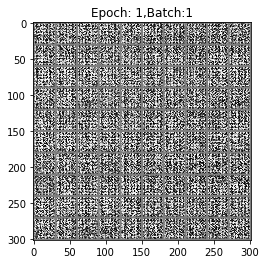

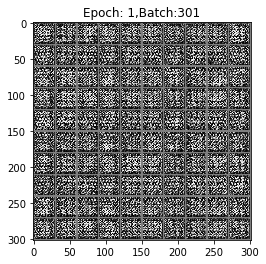

[1/20]: loss_d: -15.795, loss_g: 9.218


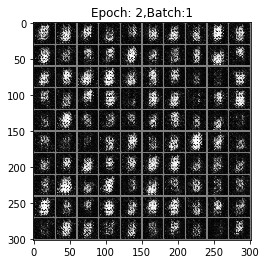

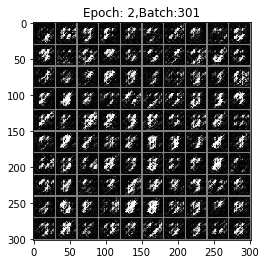

[2/20]: loss_d: -39.359, loss_g: 23.737


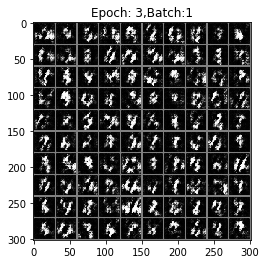

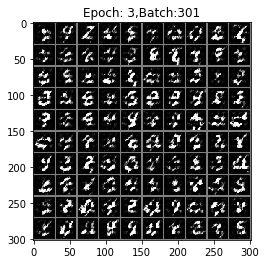

[3/20]: loss_d: -53.569, loss_g: 34.174


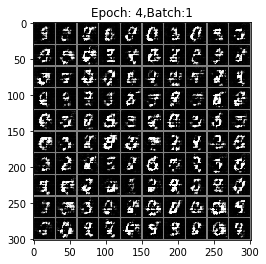

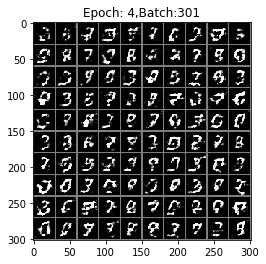

[4/20]: loss_d: -57.280, loss_g: 40.135


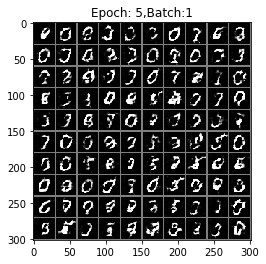

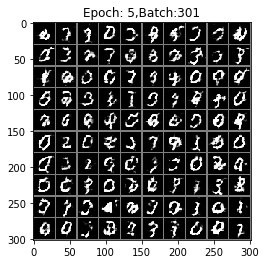

[5/20]: loss_d: -57.075, loss_g: 43.706


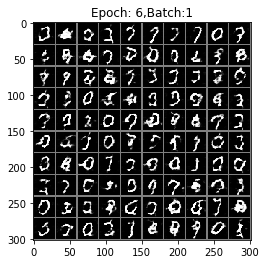

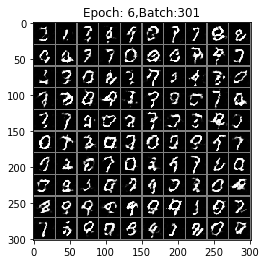

[6/20]: loss_d: -55.508, loss_g: 47.132


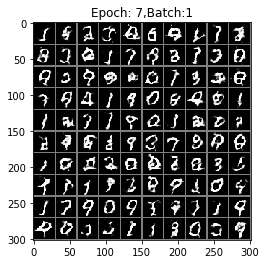

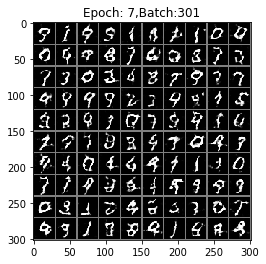

[7/20]: loss_d: -53.308, loss_g: 50.140


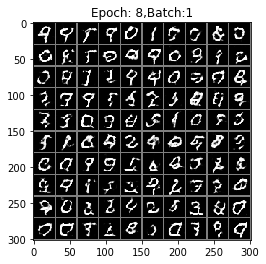

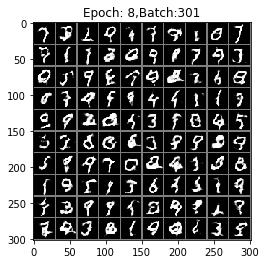

[8/20]: loss_d: -51.114, loss_g: 52.769


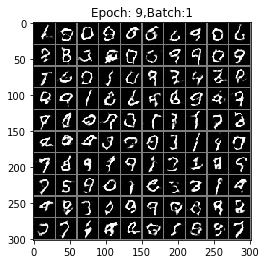

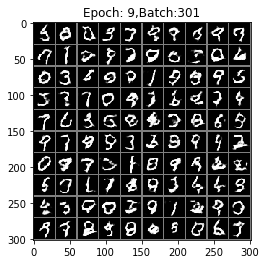

[9/20]: loss_d: -48.712, loss_g: 55.802


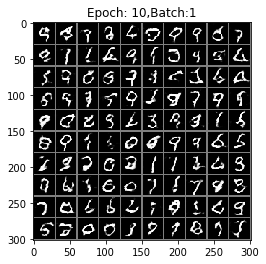

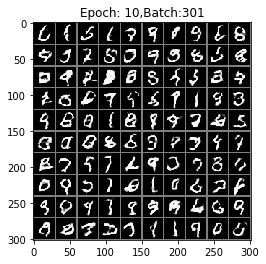

[10/20]: loss_d: -46.475, loss_g: 58.896


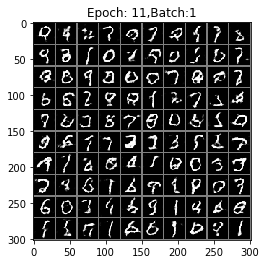

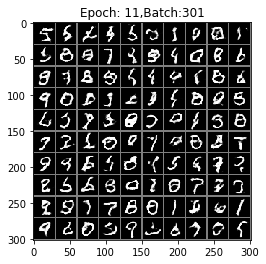

[11/20]: loss_d: -44.598, loss_g: 61.872


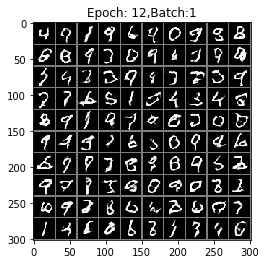

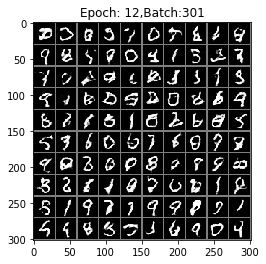

[12/20]: loss_d: -42.808, loss_g: 64.766


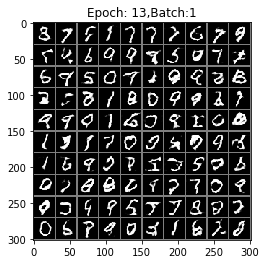

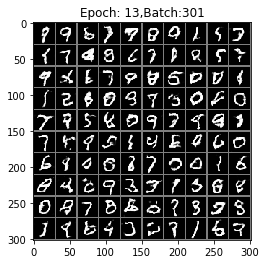

[13/20]: loss_d: -41.228, loss_g: 67.614


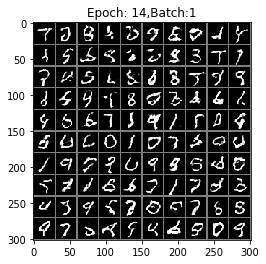

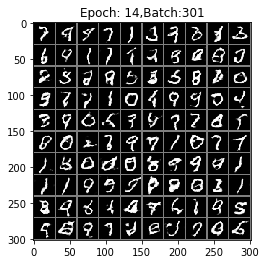

[14/20]: loss_d: -39.793, loss_g: 70.512


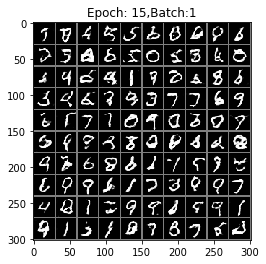

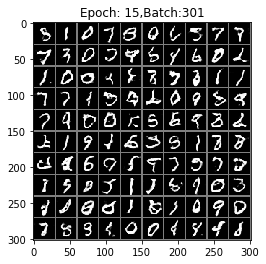

[15/20]: loss_d: -38.482, loss_g: 73.512


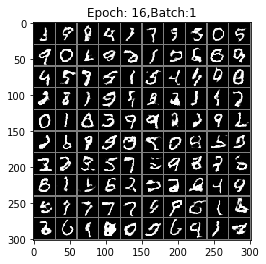

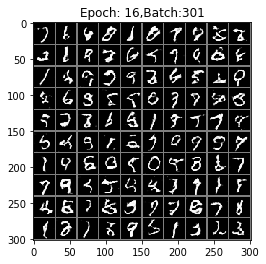

[16/20]: loss_d: -37.245, loss_g: 76.281


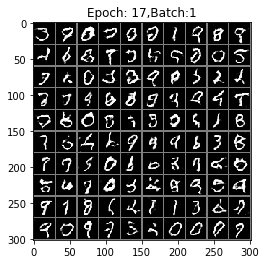

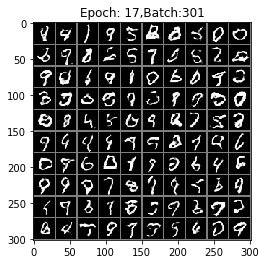

[17/20]: loss_d: -36.165, loss_g: 78.974


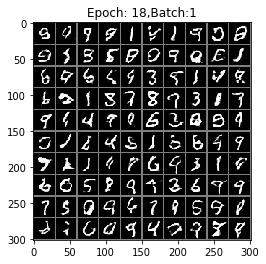

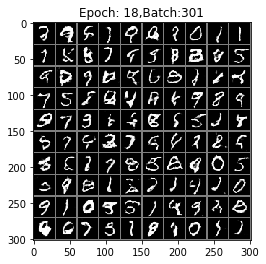

[18/20]: loss_d: -35.259, loss_g: 81.588


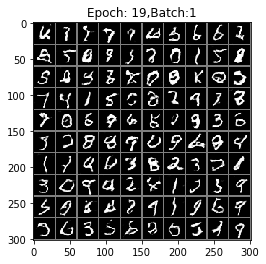

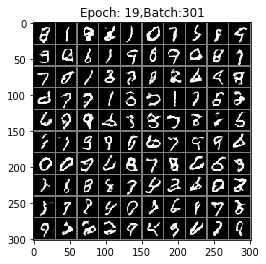

[19/20]: loss_d: -34.434, loss_g: 84.272


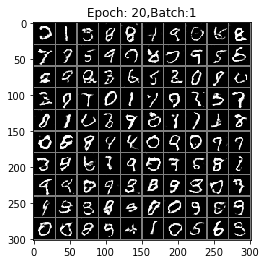

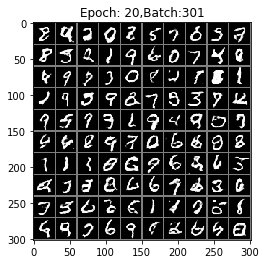

[20/20]: loss_d: -33.593, loss_g: 86.862


In [13]:
n_epoch = 20
D_losses, G_losses = [], []

for epoch in range(1, n_epoch+1):           
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_loss,gen_data=G_train(x)
        G_losses.append(G_loss)
        if batch_idx %300 ==0:
            gen_data=gen_data.view(100,1,28,28)
            grid_img = torchvision.utils.make_grid(gen_data, nrow=10)
            plt.figure()
            plt.title(f"Epoch: {epoch},Batch:{batch_idx+1}")
            plt.imshow(grid_img.cpu().permute(1,2,0)*0.5+0.5)
            plt.show()

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

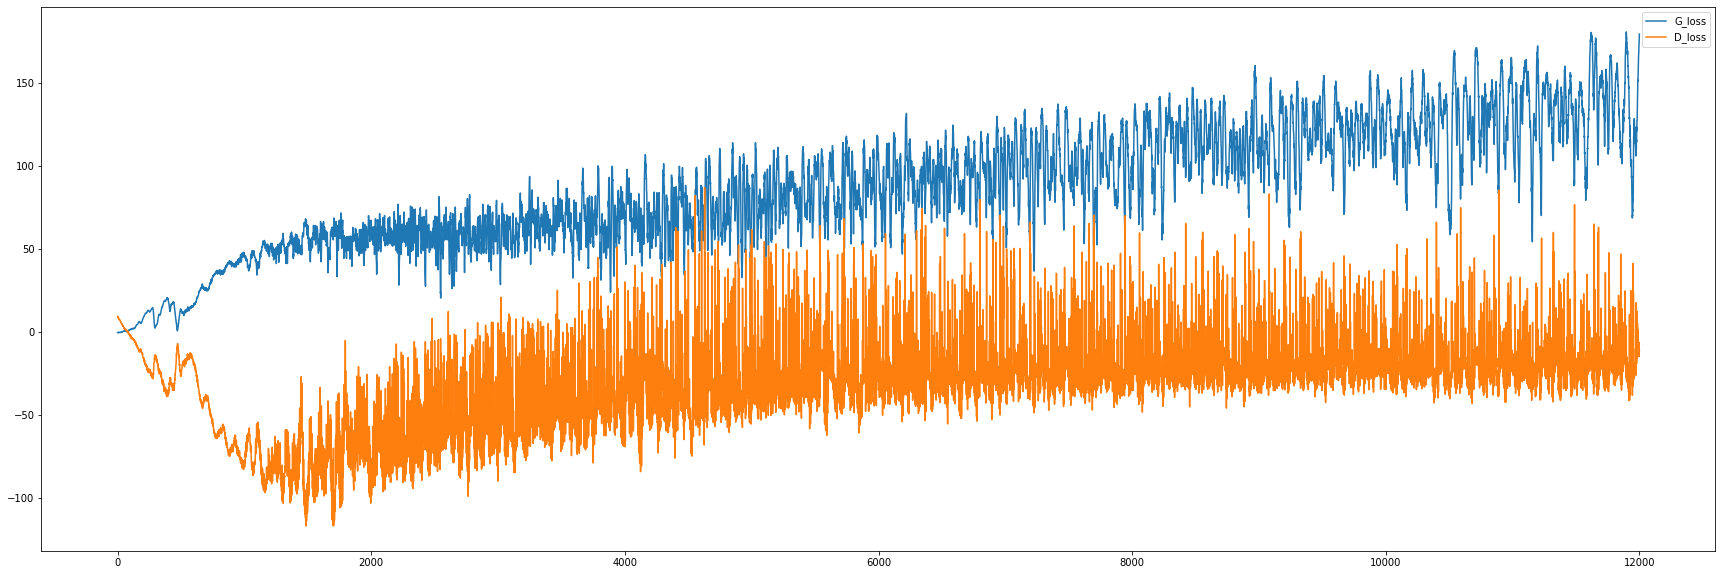

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
plt.plot(G_losses,label='G_loss')
plt.plot(D_losses,label='D_loss')
plt.legend()

#plt.legend("D_losses")
